In [3]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import scoping.models as sm
import igraph
#import mpld3

from adjustText import adjust_text

print(igraph.__version__)
print(sns.__version__)

0.7.1
0.9.0


In [4]:
# set seed
random.seed(123)

In [3]:
# create project and save tweets to project for easier callup 
p, created = sm.Project.objects.get_or_create(title='Coal Commission')
p.pk

196

In [5]:
p = sm.Project.objects.get(pk=196)

In [6]:
terms =  [
    '#Kohlekommission',
    '#Kohleausstieg',
    '#Hambibleibt'
]

In [6]:
for t in terms:
    s, created = tm.TwitterSearch.objects.get_or_create(string=t)
    s.project = p
    s.save()
    print(f"\n{s.string}: {s.status_set.count()}")
    if s.status_set.count() > 1:
        ms = s.status_set.order_by('-retweets_count').first()
        print(f"most retweeted: {ms.retweets_count}")
        print(f"{ms.author} - {ms.created_at}")
        print(ms.text)


#Kohlekommission: 13956
most retweeted: 409
campact - @campact - 2018-08-24 09:42:14+00:00
Wenn es nach @RWE_AG geht, soll einer der ältesten Wälder Deutschlands für eine Technologie weichen, deren Ende beschlossene Sache ist. Wir appellieren an die #Kohlekommission und die #Bundesregierung: Retten Sie den #HambacherForst! Hier unterzeichnen: https://t.co/lsjUFgc1NX https://t.co/nR6vJI826G

#Kohleausstieg: 56275
most retweeted: 538
Ralph Goldmann - @RalphGoldmann - 2019-06-21 12:07:32+00:00
Das muss man hochkant sehen. 😳 #FridaysForFurture #aachen #AC2106 #kohleausstieg @ZDFheute pic.twitter.com/5DpBpDbjKm

#Hambibleibt: 121799
most retweeted: 1180
Raphael Thelen - @RaphaelThelen - 2018-10-06 13:14:12+00:00
Die neuen besorgten Bürger: - 50.000 Menschen bei #Hambibleibt - 30.000 Menschen bei #wellcomeunited in Hamburg - 100.000 bei der #Seebrücke in ganz Deutschland - 65.000 bei #wirsindmehr in Chemnitz - 40.000 bei #nopag und #ausgehetzt in München Ist das der Linksruck?


In [7]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True
).values_list('id',flat=True))

print(len(ttweets))

180766


In [8]:
# Take a sample of the texts
texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 20000)
).values_list('text',flat=True)


# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf = vectorizer.fit_transform(texts)

In [9]:
# Run tm on tweets to get general idea 
K = 10

model = NMF(
    n_components=K, random_state=1,
    alpha=0.01, l1_ratio=.91,
    init='nndsvd'
).fit(tfidf)

dtm = model.transform(tfidf)

In [10]:
tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


##############################################
### Topic 0
hambibleibt endegela mensch hambacherwald heut schon wald mal mehr alledorferbleib


@HambiBleibt @HambacherF @anettselle @Dumpsterdive @HambiBleibt Bitte geht hin. Schmeisst dir arbeit für die Zukunft. Der Chef wird es verstehen. Oder mitgehn. 1000 können sie nicht stoppen! Please damit #StopptdenWahnsinn #Hambibleibt #hambacherforst #hambi

Have a look on what pro #RWE people think abaout meanwhile...
#HambiBleibt #HambiBleibt #HambiBleibt ✊❤💚 https://t.co/pWuna9MyBw

15:20 Police came to declare that we are an illegal occupation. 15:28,they made the second declaration. #wildewaldbleibt #hambibleibt @Ende_GelaendeHH #hambibleibt @EAHambi @HambiBleibt

#HAMBIBLEIBT #hambibleibt #HAMBIBLEIBT #HambacherForst

All over Germany, people are gathering in the streets right now chanting #hambibleibt . I am in Hamburg, at central station, on the way home to Berlin, hearing protesters loud and clear #hambibleibt @HambiBleibt #EndCoal



In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
print_top_words(model, tfidf_feature_names, 10)


Topic #0:
hambibleibt endegela mensch hambacherwald heut schon wald mal mehr alledorferbleib

Topic #1:
the end natur gretathunberg peopl germany again our mor hambach

Topic #2:
kohleausstieg klimaschutz energiew kohl klimawandel deutschland fridaysforfutur endegela mehr cdu

Topic #3:
hambacherforst hambi hambacherwald hambibleibt polizei raumung endegeland hambacherfor noblackout lori

Topic #4:
the for coal you with from are peopl hav solidarity

Topic #5:
rwe braunkohl rweag mehr arminlaschet reul wald jahr useronlin nrw

Topic #6:
hambi fridaysforfutur climatejustic endcoal extinctionrebellion gretathunberg climatechang climatestr climateemergency volksbegehrenartenvielfalt

Topic #7:
geht endcoal via campact appell unterzeichn groko klimaziel gar aufgeb

Topic #8:
kohlekommission braunkohl amp kohl mehr heut deutschland klimaschutz coal ergebnis

Topic #9:
hambach forst wald hambibleibt raumung aach polizei for tagebau rodung



In [12]:
nmf_embedding = model.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=123)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [14]:
tsne_embedding[:10]

,x,y,hue
0,8.377333,54.442310,2
1,-28.773634,72.031372,2
2,77.148857,5.633877,2
3,-28.011688,58.651272,2
4,-26.149084,45.578400,2
5,-6.605794,52.129299,2
6,-45.035568,47.065598,2
7,-6.053625,47.885502,2
8,-6.053625,47.885502,2
9,-41.167259,70.239845,2


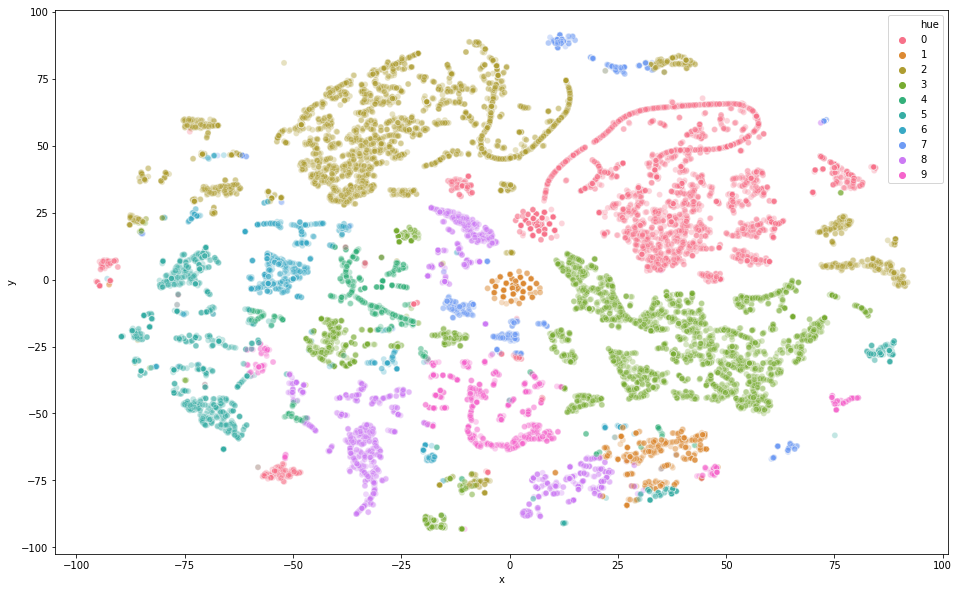

In [17]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_embedding['x'], y=tsne_embedding['y'],
    hue=tsne_embedding['hue'],
    palette=sns.color_palette("husl", 10),
    legend="full",
    alpha=0.3
)